# Processing Sequences Using RNNs

In this notebook, we'll tackle a time-series forecasting problem using recurrent neural networks. Specifically, we'll work on building a model capable of forecasting the number of passengers that will ride on bus and rail the next day. We'll have access to daily ridership data since 2001.


## Setup

In [1]:
import tensorflow as tf

In [2]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

## Basic RNNs

Let's download the ridership data from the ageron/data project. It originally comes from Chicago's Transit Authority, and was downloaded from the [Chicago's Data Portal](https://homl.info/ridership).

In [3]:
tf.keras.utils.get_file(
    "ridership.tgz",
    "https://github.com/ageron/data/raw/main/ridership.tgz",
    cache_dir=".",
    extract=True
)

108512/108512 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step


'./datasets/ridership.tgz'

First, we'll load the CSV file, set shorter column names, sort the rows by date, remove the redundant total column, and drop duplicate rows.

In [4]:
import pandas as pd
from pathlib import Path

path = Path("datasets/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]  # shorter names
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)  # no need for total, it's just bus + rail
df = df.drop_duplicates()  # remove duplicated months (2011-10 and 2014-07)

Now let's check what the first few rows look like:

In [5]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


On January 1st, 2001, 297,192 people boarded a bus in Chicago, and 126,455 boarded a train. The `day_type` column contains *W* for Weekdays, *A* for Saturdays, and *U* for Sundays or holidays.

Let's look at the first few months of 2019 (note that Pandas treats the range boundaries as inclusive):

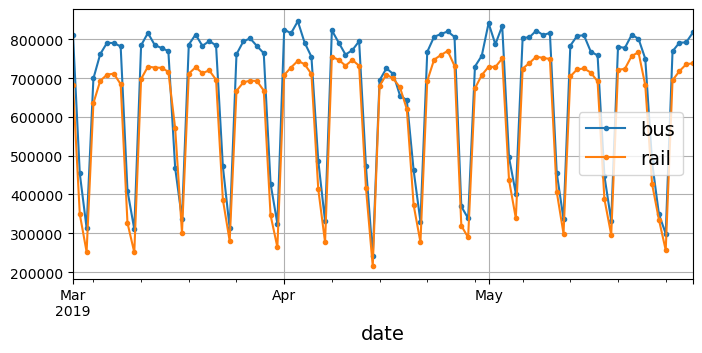

In [6]:
import matplotlib.pyplot as plt
date_range = slice("2019-03", "2019-05")

df[date_range].plot(grid=True, marker=".", figsize=(8, 3.5))
plt.show()

This is a time series: data with values at different time steps, usually at regular intervals. More specifically, since there are multiple values per time step, this is called a multivariate time series. If we only looked at the bus column, it would be a univariate time series, with a single value per time step. Predicting future values (i.e., forecasting) is the most typical task when dealing with time series, and this is what we will focus on.

Looking at the graph, we can see that a similar pattern is clearly repeated every week. This is called a weekly seasonality. In fact, it's so strong in this case that forecasting tomorrow's ridership by just copying the values from a week earlier will yield reasonably good results. This is called *naive forecasting*: simply copying a past value to make our forecast. Naive forecasting is often a great baseline, and it can even be tricky to beat in some cases.

To visualize these naive forecasts, let's overlay the two time series (for bus and rail) as well as the same time series lagged by one week (i.e., shifted toward the right) using dotted lines. We'll also plot the difference between the two (i.e., the value at time $t$ minus the value at time $t-7$); this is called differencing.

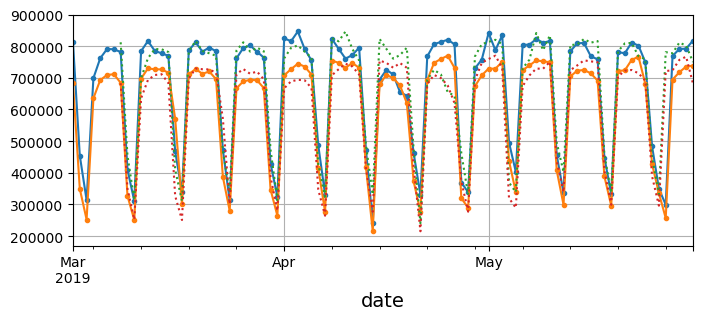

In [7]:
fig, axs = plt.subplots(sharex=True, figsize=(8, 3))
df[date_range].plot(ax=axs, legend=False, marker=".")  # original time series
df[date_range].shift(7).plot(ax=axs, grid=True, legend=False, linestyle=":")  # lagged
axs.set_ylim([170_000, 900_000])  # extra code – beautifies the plot
plt.show()

Notice how closely the lagged time series track the actual time series. When a time series is correlated with a lagged version of itself, we say that the time series is autocorrelated.

We can now measure the mean absolute error (MAE) over the three-month period we're arbitrarily focusing on to get a rough idea of how good our naive forecast is:

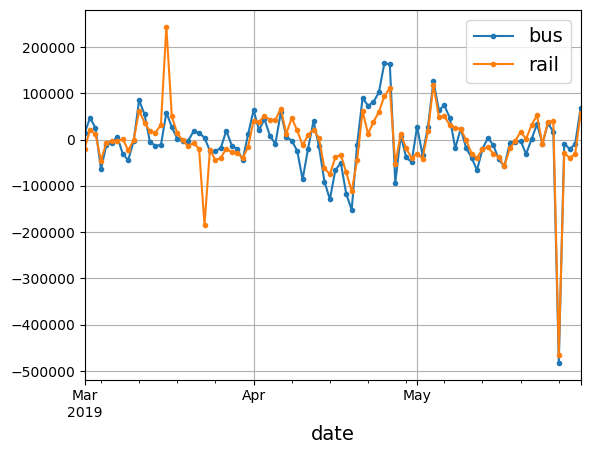

In [8]:
diff_7 = df[["bus", "rail"]].diff(7)[date_range]

diff_7.plot(grid=True, marker=".")  # 7-day difference time series
plt.show()

In [9]:
diff_7.abs().mean()

bus     43915.608696
rail    42143.271739
dtype: float64

Our naive forecasts get an MAE of about 43,916 bus riders, and about 42,143 rail riders. It's hard to tell at a glance how good or bad this is, so let's put the forecast errors into perspective by dividing them by the target values, this is called mean absolute percentage error (MAPE):

In [10]:
targets = df[["bus", "rail"]][date_range]
(diff_7 / targets).abs().mean()

bus     0.082938
rail    0.089948
dtype: float64

It looks like our naive forecasts give us a MAPE of roughly 8.3% for bus and 9.0% for rail.

## Preparing the Data for Machine Learning Models

Now that we have a baseline, let’s try to use machine learning models to forecast this time series, starting with a basic linear model. Our goal will be to forecast tomorrow’s rail ridership based on the ridership of the past 8 weeks of data (56 days). The inputs to our model will therefore be sequences (usually a single sequence per day once the model is in production), each containing 56 values from time steps `t – 55` to `t`. For each input sequence, the model will output a single value: the forecast for time step `t + 1`.

For training data, we will use every 56-day window from the past, and the target for each window will be the value immediately following it.

Keras has a nice utility function called `tf.keras.utils.timeseries_​data⁠set_from_array()` to help us prepare the training set. It takes a time series as input, and it builds a `tf.data.Dataset` containing all the windows of the desired length, as well as their corresponding targets. Here’s an example that takes a time series containing the numbers 0 to 5 and creates a dataset containing all the windows of length 3, with their corresponding targets, grouped into batches of size 2:

In [11]:
import tensorflow as tf

my_series = [0, 1, 2, 3, 4, 5]
my_dataset = tf.keras.utils.timeseries_dataset_from_array(
    my_series,
    targets=my_series[3:],  # the targets are 3 steps into the future
    sequence_length=3,
    batch_size=2
)
list(my_dataset)

2024-10-29 19:38:53.966192: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]], dtype=int32)>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[2, 3, 4]], dtype=int32)>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5], dtype=int32)>)]

Each sample in the dataset is a window of length 3, along with its corresponding target (i.e., the value immediately after the window). The windows are [0, 1, 2], [1, 2, 3], and [2, 3, 4], and their respective targets are 3, 4, and 5. Since there are three windows in total, which is not a multiple of the batch size, the last batch only contains one window instead of two.

Before we start training, we need to split our data into a training period, a validation period, and a test period. We will focus on the rail ridership for now. We will also scale it down by a factor of one million, to ensure the values are near the $0-1$ range; this plays nicely with the default weight initialization and learning rate:

In [12]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

Next, let’s use `timeseries_dataset_from_array()` to create datasets for training and validation. Since gradient descent expects the instances in the training set to be independent and identically distributed (IID), we must set the argument `shuffle=True` to shuffle the training windows (but not their contents):

In [13]:
seq_length = 56
tf.random.set_seed(42)  # extra code – ensures reproducibility
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)

valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

## Forecasting Using a Linear Model

Let's try a basic linear model first. We will use the Huber loss, which usually works better than minimizing the MAE directly. We'll also use early stopping.


In [14]:
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[seq_length]),
    tf.keras.layers.Dense(1)
])

model.summary()

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True)

opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])

history = model.fit(train_ds, validation_data=valid_ds, epochs=500,
                    callbacks=[early_stopping_cb])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │            57 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57 (228.00 B)

 Trainable params: 57 (228.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2272 - mae: 0.5522 - val_loss: 0.0134 - val_mae: 0.1360
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0147 - mae: 0.1372 - val_loss: 0.0050 - val_mae: 0.0709
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0066 - mae: 0.0829 - val_loss: 0.0046 - val_mae: 0.0675
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0071 - mae: 0.0854 - val_loss: 0.0043 - val_mae: 0.0633
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0061 - mae: 0.0801 - val_loss: 0.0042 - val_mae: 0.0626
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0053 - mae: 0.0733 - val_loss: 0.0040 - val_mae: 0.0617
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0050 - mae: 0.0705 - val_loss: 0.0040 - val_mae: 0.0631
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0062 - mae: 0.0805 - val_loss: 0.0039 - val_mae: 0.0613
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.005

In [15]:
valid_loss, valid_mae = model.evaluate(valid_ds)
valid_mae * 1e6

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0019 - mae: 0.0398 


38187.1722638607

This model reaches a validation MAE of about 38,000. That’s better than naive forecasting, but we can do better using a recurrent model.

## Using a Simple RNN

Let’s try the most basic RNN, containing a single recurrent layer with just one recurrent neuron.

In [16]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[None, 1]),
    tf.keras.layers.SimpleRNN(1)
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3 (12.00 B)

 Trainable params: 3 (12.00 B)

 Non-trainable params: 0 (0.00 B)

All recurrent layers in Keras expect 3D inputs of shape `[batch size, time steps, dimensionality]`, where dimensionality is 1 for univariate time series and more for multivariate time series. Recall that the `shape` argument ignores the first dimension (i.e., the batch size), and since recurrent layers can accept input sequences of any length, we can set the second dimension to `None`, which means "any size". Lastly, since we’re dealing with a univariate time series, we need the last dimension’s size to be 1. This is why we specified the input shape `[None, 1]`: it means "univariate sequences of any length".

In [17]:
def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=50, restore_best_weights=True)

    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])

    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])

    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6

In [18]:
fit_and_evaluate(model, train_ds, valid_ds, learning_rate=0.02)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2713 - mae: 0.5671 - val_loss: 0.0162 - val_mae: 0.1749
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0295 - mae: 0.1909 - val_loss: 0.0391 - val_mae: 0.2207
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0282 - mae: 0.1732 - val_loss: 0.0145 - val_mae: 0.1487
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0152 - mae: 0.1604 - val_loss: 0.0147 - val_mae: 0.1372
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0147 - mae: 0.1504 - val_loss: 0.0144 - val_mae: 0.1386
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0153 - mae: 0.1577 - val_loss: 0.0146 - val_mae: 0.1339
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0144 - mae: 0.1495 - val_loss: 0.0142 - val_mae: 0.1366
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0148 - mae: 0.1546 - val_loss: 0.0141 - val_mae: 0.1349
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.014

102804.44473028183

After training, notice our model's validation MAE is greater than 100,000! That was to be expected, for two reasons:

1. The model only has a single recurrent neuron, so the only data it can use to make a prediction at each time step is the input value at the current time step and the output value from the previous time step. In other words, the RNN's memory is extremely limited: it's just a single number, its previous output. Also, since there's just one recurrent neuron with only two input values, the whole model only has three parameters (two weights plus a bias term). That's far from enough for this time series.
2. The time series contains values from $0$ to about $1.4$, but since the default activation function is `tanh`, the recurrent layer can only output values between $-1$ and $+1$. There's no way it can predict values between $1.0$ and $1.4$.

Let's fix both of these issues: we will create a model with a larger recurrent layer, containing 32 recurrent neurons, and we will add a dense output layer on top of it with a single output neuron and no activation function. The recurrent layer will be able to carry much more information from one time step to the next, and the dense output layer will project the final output from 32 dimensions down to 1, without any value range constraints:

In [19]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
univar_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)  # no activation function by default
])

univar_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 32)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,121 (4.38 KB)

 Trainable params: 1,121 (4.38 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
fit_and_evaluate(univar_model, train_ds, valid_ds, learning_rate=0.05)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0726 - mae: 0.3025 - val_loss: 0.0049 - val_mae: 0.0770
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0057 - mae: 0.0818 - val_loss: 0.0034 - val_mae: 0.0657
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0038 - mae: 0.0613 - val_loss: 0.0025 - val_mae: 0.0494
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mae: 0.0507 - val_loss: 0.0027 - val_mae: 0.0502
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0035 - mae: 0.0516 - val_loss: 0.0025 - val_mae: 0.0409
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0033 - mae: 0.0499 - val_loss: 0.0021 - val_mae: 0.0338
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0028 - mae: 0.0450 - val_loss: 0.0022 - val_mae: 0.0376
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mae: 0.0459 - val_loss: 0.0029 - val_mae: 0.0543
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.003

27990.078553557396

Now if you compile, fit, and evaluate this model just like the previous one, you will find that its validation MAE reaches about 30k. That's the best result we've got so far.

## Deep RNNs

Implementing a deep RNN with Keras is straightforward: just stack recurrent layers.

In the following example, we use three `SimpleRNN layers` (but we could use any other type of recurrent layer instead, such as an `LSTM` layer or a `GRU` layer). The first two are sequence-to-sequence layers, and the last one is a sequence-to-vector layer. When stacking RNN layers it is fundamental we pass the full output of a hidden layer to the next layer or else the output and input dimensions of these layers won't match.

Finally, the `Dense` layer produces the model's forecast (you can think of it as a vector-to-vector layer).



In [21]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
deep_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True), # Passes full output to
    tf.keras.layers.SimpleRNN(32, return_sequences=True), # next layer
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

deep_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, None, 32)       │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, None, 32)       │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_4 (SimpleRNN)        │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,281 (20.63 KB)

 Trainable params: 5,281 (20.63 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=0.01)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0422 - mae: 0.2065 - val_loss: 0.0118 - val_mae: 0.1348
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0126 - mae: 0.1416 - val_loss: 0.0081 - val_mae: 0.0915
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0076 - mae: 0.0975 - val_loss: 0.0036 - val_mae: 0.0676
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0060 - mae: 0.0768 - val_loss: 0.0034 - val_mae: 0.0627
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0059 - mae: 0.0757 - val_loss: 0.0027 - val_mae: 0.0543
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0050 - mae: 0.0709 - val_loss: 0.0035 - val_mae: 0.0615
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0041 - mae: 0.0615 - val_loss: 0.0024 - val_mae: 0.0489
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0047 - mae: 0.0657 - val_loss: 0.0039 - val_mae: 0.0667
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - lo

29992.328956723213

If you train and evaluate this model, you will find that it reaches an MAE of about 27k. That's better than the baseline and the "shallower" RNN we trained before.

## Multivariate time series

A great quality of neural networks is their flexibility: in particular, they can deal with multivariate time series with almost no change to their architecture. For example, let’s try to forecast the rail time series using both the bus and rail data as input, as well as the day type (since we can always know in advance whether tomorrow is going to be a weekday, a weekend, or a holiday, we can shift the day type series one day into the future, so that the model is given tomorrow’s day type as input). For simplicity, we’ll do this processing using Pandas:

In [23]:
df_mulvar = df[["bus", "rail"]] / 1e6  # use both bus & rail series as input
df_mulvar["next_day_type"] = df["day_type"].shift(-1)  # we know tomorrow's type
df_mulvar = pd.get_dummies(df_mulvar)  # one-hot encode the day type
df_mulvar.head()

,bus,rail,next_day_type_A,next_day_type_U,next_day_type_W
date,,,,,
2001-01-01,0.297192,0.126455,False,False,True
2001-01-02,0.780827,0.501952,False,False,True
2001-01-03,0.824923,0.536432,False,False,True
2001-01-04,0.870021,0.550011,False,False,True
2001-01-05,0.890426,0.557917,True,False,False


Now `df_mulvar` is a `DataFrame` with five columns: the bus and rail data, plus three columns containing the one-hot encoding of the next day’s type (recall that there are three possible day types, W, A, and U). Next we can proceed much like we did earlier. First we split the data into three periods, for training, validation, and testing:

In [24]:
mulvar_train = df_mulvar["2016-01":"2018-12"]
mulvar_valid = df_mulvar["2019-01":"2019-05"]
mulvar_test = df_mulvar["2019-06":]

Then we create the datasets:

In [25]:
tf.random.set_seed(42)  # extra code – ensures reproducibility

train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy().astype('float32'),  # use all 5 columns as input
    targets=mulvar_train["rail"][seq_length:],  # forecast only the rail series
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)

valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy().astype('float32'),
    targets=mulvar_valid["rail"][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

And finally we create the RNN:

In [26]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
mulvar_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[None, 5]),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

mulvar_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_5 (SimpleRNN)        │ (None, 32)             │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,249 (4.88 KB)

 Trainable params: 1,249 (4.88 KB)

 Non-trainable params: 0 (0.00 B)

Notice that the only difference from the `univar_model` RNN we built earlier is the input shape: at each time step, the model now receives five inputs instead of one.

In [27]:
fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds,
                 learning_rate=0.05)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2338 - mae: 0.5342 - val_loss: 0.0054 - val_mae: 0.0941
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0052 - mae: 0.0769 - val_loss: 8.2767e-04 - val_mae: 0.0293
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0023 - mae: 0.0486 - val_loss: 0.0043 - val_mae: 0.0841
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0023 - mae: 0.0496 - val_loss: 8.1336e-04 - val_mae: 0.0306
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0020 - mae: 0.0429 - val_loss: 0.0011 - val_mae: 0.0361
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014 - mae: 0.0364 - val_loss: 6.6471e-04 - val_mae: 0.0254
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0017 - mae: 0.0409 - val_loss: 6.5847e-04 - val_mae: 0.0250
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016 - mae: 0.0397 - val_loss: 6.7367e-04 - val_mae: 0.0260
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4m

22475.382313132286

This model reaches a validation MAE of about 23k.

In fact, it's not too hard to make the RNN forecast both the bus and rail ridership. You just need to change the targets when creating the datasets, setting them to `mulvar_train[["bus", "rail"]][seq_length:]` for the training set, and `mulvar_valid[["bus", "rail"]][seq_length:]` for the validation set. You must also add an extra neuron in the output Dense layer, since it must now make two forecasts: one for tomorrow's bus ridership, and the other for rail.

In [28]:
tf.random.set_seed(42)

seq_length = 56
train_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy().astype('float32'),
    targets=mulvar_train[["bus", "rail"]][seq_length:],  # 2 targets per day
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)

valid_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy().astype('float32'),
    targets=mulvar_valid[["bus", "rail"]][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

multask_model = tf.keras.Sequential([
    tf.keras.Input(shape=[None, 5]),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(2)
])

multask_model.summary()

fit_and_evaluate(multask_model, train_multask_ds, valid_multask_ds,
                 learning_rate=0.02)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_6 (SimpleRNN)        │ (None, 32)             │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,282 (5.01 KB)

 Trainable params: 1,282 (5.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1403 - mae: 0.3871 - val_loss: 0.0027 - val_mae: 0.0602
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0041 - mae: 0.0691 - val_loss: 0.0012 - val_mae: 0.0381
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0021 - mae: 0.0471 - val_loss: 0.0012 - val_mae: 0.0384
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0018 - mae: 0.0420 - val_loss: 9.3272e-04 - val_mae: 0.0336
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0019 - mae: 0.0414 - val_loss: 0.0016 - val_mae: 0.0458
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0017 - mae: 0.0419 - val_loss: 8.4877e-04 - val_mae: 0.0317
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016 - mae: 0.0395 - val_loss: 9.1222e-04 - val_mae: 0.0326
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0017 - mae: 0.0394 - val_loss: 7.4332e-04 - val_mae: 0.0287
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/st

25158.08492898941

In [29]:
# Evaluate independent Bus and Rail MAEs
Y_preds_valid = multask_model.predict(valid_multask_ds)
for idx, name in enumerate(["bus", "rail"]):
    mae = 1e6 * tf.keras.metrics.MAE(
        mulvar_valid[name][seq_length:], Y_preds_valid[:, idx])
    print(name, int(mae))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
bus 25866
rail 24449


Using a single model for multiple related tasks often results in better performance than using a separate model for each task, since features learned for one task may be useful for the other tasks, and also because having to perform well across multiple tasks prevents the model from overfitting (it's a form of regularization). However, it depends on the task, and in this particular case the multitask RNN that forecasts both the bus and the rail ridership doesn't perform quite as well as dedicated models that forecast one or the other (using all five columns as input). Still, it reaches a validation MAE of 23k for rail and 25k for bus, which is pretty good.

## Forecasting Several Steps Ahead

So far we have only predicted the value at the next time step, but we could just as easily have predicted the value several steps ahead by changing the targets appropriately (e.g., to predict the ridership 2 weeks from now, we could just change the targets to be the value 14 days ahead instead of 1 day ahead). But what if we want to predict the next 14 values?

One option is to take the `univar_model` RNN we trained earlier for the rail time series, make it predict the next value, and add that value to the inputs, acting as if the predicted value had actually occurred; we would then use the model again to predict the following value, and so on, as in the following code:

In [30]:
import numpy as np

X = rail_valid.to_numpy()[np.newaxis, :seq_length, np.newaxis]
for step_ahead in range(14):
    y_pred_one = univar_model.predict(X)
    X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)
y_pred_one

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


array([[0.6660387]], dtype=float32)

In this code, we took the rail ridership of the first 56 days of the validation period, and we convert the data to a NumPy array of shape `[1, 56, 1]` (recall that recurrent layers expect 3D inputs). Then we repeatedly use the model to forecast the next value, and we append each forecast to the input series, along the time axis (`axis=1`).

We can plot our results and compare them with the actual data.

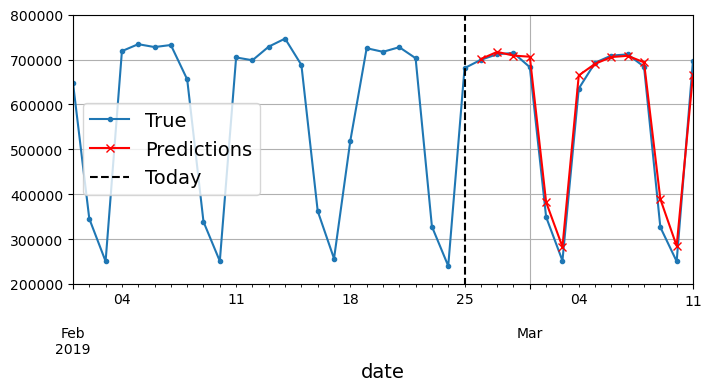

In [31]:
# The forecasts start on 2019-02-26, as it is the 57th day of 2019, and they end
# on 2019-03-11. That's 14 days in total.
Y_pred = pd.Series(X[0, -14:, 0],
                   index=pd.date_range("2019-02-26", "2019-03-11"))

fig, ax = plt.subplots(figsize=(8, 3.5))
(rail_valid * 1e6)["2019-02-01":"2019-03-11"].plot(
    label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(
    label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines("2019-02-25", 0, 1e6, color="k", linestyle="--", label="Today")
ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
plt.show()

One important consideration is that if the model makes an error at one time step, then the forecasts for the following time steps are impacted as well: the errors tend to accumulate. So, it's preferable to use this technique only for a small number of steps.



The second option is to train an RNN to predict the next 14 values in one shot. We can still use a sequence-to-vector model, but it will output 14 values instead of 1. However, we first need to change the targets to be vectors containing the next 14 values. To do this, we can use `timeseries_dataset_from_array()` again, but this time asking it to create datasets without targets (`targets=None`) and with longer sequences, of length `seq_length + 14`. Then we can use the datasets' `map()` method to apply a custom function to each batch of sequences, splitting them into inputs and targets. In this example, we use the multivariate time series as input (using all five columns), and we forecast the rail ridership for the next 14 days.

In [32]:
tf.random.set_seed(42)
def split_inputs_and_targets(mulvar_series, ahead=14, target_col=1):
    return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy().astype('float32'),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32,
    shuffle=True,
    seed=42
).map(split_inputs_and_targets)

ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy().astype('float32'),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32
).map(split_inputs_and_targets)

Now we just need the output layer to have 14 units instead of 1:

In [33]:
tf.random.set_seed(42)

ahead_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[None, 5]),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(14)
])

ahead_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_7 (SimpleRNN)        │ (None, 32)             │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 14)             │           462 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,678 (6.55 KB)

 Trainable params: 1,678 (6.55 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
fit_and_evaluate(ahead_model, ahead_train_ds, ahead_valid_ds,
                 learning_rate=0.02)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1831 - mae: 0.4882 - val_loss: 0.0237 - val_mae: 0.1742
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0201 - mae: 0.1575 - val_loss: 0.0110 - val_mae: 0.1189
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0127 - mae: 0.1248 - val_loss: 0.0090 - val_mae: 0.1028
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0104 - mae: 0.1110 - val_loss: 0.0072 - val_mae: 0.0930
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0090 - mae: 0.1032 - val_loss: 0.0062 - val_mae: 0.0864
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0083 - mae: 0.0974 - val_loss: 0.0057 - val_mae: 0.0823
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0078 - mae: 0.0927 - val_loss: 0.0050 - val_mae: 0.0779
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0070 - mae: 0.0884 - val_loss: 0.0047 - val_mae: 0.0753
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.006

34795.77973484993

After training this model, you can predict the next 14 values at once like this:

In [35]:
X = mulvar_valid.to_numpy().astype('float32')[np.newaxis, :seq_length]  # shape [1, 56, 5]
Y_pred = ahead_model.predict(X)  # shape [1, 14]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


In [36]:
Y_true = mulvar_valid.to_numpy()[np.newaxis, seq_length:seq_length+14, 1]
Y_true

array([[0.699462, 0.711827, 0.7147, 0.682969, 0.349392, 0.25215,
        0.635353, 0.692945, 0.708876, 0.711428, 0.684186, 0.326686,
        0.250702, 0.697758]], dtype=object)

In [37]:
Y_pred

array([[0.7194684 , 0.7384616 , 0.7175526 , 0.6785066 , 0.37137276,
        0.28461263, 0.6315292 , 0.727584  , 0.7050156 , 0.71627873,
        0.66955   , 0.37138873, 0.26712015, 0.67111456]], dtype=float32)

In [38]:
print("MAE:", int(tf.keras.metrics.MAE(Y_true, Y_pred) * 1e6))

MAE: 18426


This approach works quite well. Its forecasts for the next day are obviously better than its forecasts for 14 days into the future, but it doesn’t accumulate errors like the previous approach did.

# Additional Info on RNNs

There are three built-in RNN layers in Keras:

1. `keras.layers.SimpleRNN`, a fully-connected RNN where the output from previous
timestep is to be fed to next timestep.

2. `keras.layers.GRU`, first proposed in
[Cho et al., 2014](https://arxiv.org/abs/1406.1078).

3. `keras.layers.LSTM`, first proposed in
[Hochreiter & Schmidhuber, 1997](https://www.bioinf.jku.at/publications/older/2604.pdf).

In early 2015, Keras had the first reusable open-source Python implementations of LSTM
and GRU.

Here is a simple example of a `Sequential` model that processes sequences of integers,
embeds each integer into a 64-dimensional vector, then processes the sequence of
vectors using a `LSTM` layer.

In [39]:
model = tf.keras.Sequential()
# Add an Embedding layer expecting input vocab of size 1000, and
# output embedding dimension of size 64.
model.add(tf.keras.layers.Embedding(input_dim=1000, output_dim=64))

# Add a LSTM layer with 128 internal units.
model.add(tf.keras.layers.LSTM(128))

# Add a Dense layer with 10 units.
model.add(tf.keras.layers.Dense(10))

model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Built-in RNNs support a number of useful features:

- Recurrent dropout, via the `dropout` and `recurrent_dropout` arguments
- Ability to process an input sequence in reverse, via the `go_backwards` argument
- Loop unrolling (which can lead to a large speedup when processing short sequences on
CPU), via the `unroll` argument
- ...and more.

For more information, see the
[RNN API documentation](https://keras.io/api/layers/recurrent_layers/).

## Outputs and states

By default, the output of a RNN layer contains a single vector per sample. This vector
is the RNN cell output corresponding to the last timestep, containing information
about the entire input sequence. The shape of this output is `(batch_size, units)`
where `units` corresponds to the `units` argument passed to the layer's constructor.

A RNN layer can also return the entire sequence of outputs for each sample (one vector
per timestep per sample), if you set `return_sequences=True`. The shape of this output
is `(batch_size, timesteps, units)`.

In [40]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=1000, output_dim=64))

# The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 256)
model.add(tf.keras.layers.GRU(256, return_sequences=True))

# The output of SimpleRNN will be a 2D tensor of shape (batch_size, 128)
model.add(tf.keras.layers.SimpleRNN(128))

model.add(tf.keras.layers.Dense(10))

model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_8 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In addition, a RNN layer can return its final internal state(s). The returned states
can be used to resume the RNN execution later, or
[to initialize another RNN](https://arxiv.org/abs/1409.3215).
This setting is commonly used in the
encoder-decoder sequence-to-sequence model, where the encoder final state is used as
the initial state of the decoder.

To configure a RNN layer to return its internal state, set the `return_state` parameter
to `True` when creating the layer. Note that `LSTM` has 2 state  tensors, but `GRU`
only has one.

To configure the initial state of the layer, just call the layer with additional
keyword argument `initial_state`.
Note that the shape of the state needs to match the unit size of the layer, like in the
example below.

In [41]:
encoder_vocab = 1000
decoder_vocab = 2000

encoder_input = tf.keras.layers.Input(shape=(None,))
encoder_embedded = tf.keras.layers.Embedding(input_dim=encoder_vocab, output_dim=64)(
    encoder_input
)

# Return states in addition to output
output, state_h, state_c = tf.keras.layers.LSTM(64, return_state=True, name="encoder")(
    encoder_embedded
)
encoder_state = [state_h, state_c]

decoder_input = tf.keras.layers.Input(shape=(None,))
decoder_embedded = tf.keras.layers.Embedding(input_dim=decoder_vocab, output_dim=64)(
    decoder_input
)

# Pass the 2 states to a new LSTM layer, as initial state
decoder_output = tf.keras.layers.LSTM(64, name="decoder")(
    decoder_embedded, initial_state=encoder_state
)
output = tf.keras.layers.Dense(10)(decoder_output)

model = tf.keras.Model([encoder_input, decoder_input], output)
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_8       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, None, 64)  │     64,000 │ input_layer_7[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, None, 64)  │    128,000 │ input_layer_8[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder (LSTM)      │ [(None, 64),      │     33,024 │ embedding_2[0][0] │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder (LSTM)      │ (None, 64)        │     33,024 │ embedding_3[0][0… │
│                     │                   │            │ encoder[0][1],    │
│                     │                   │            │ encoder[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 10)        │        650 │ decoder[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 258,698 (1010.54 KB)

 Trainable params: 258,698 (1010.54 KB)

 Non-trainable params: 0 (0.00 B)

## Bidirectional RNNs

For sequences other than time series (e.g. text), it is often the case that a RNN model
can perform better if it not only processes sequence from start to end, but also
backwards. For example, to predict the next word in a sentence, it is often useful to
have the context around the word, not only just the words that come before it.

Keras provides an easy API for you to build such bidirectional RNNs: the
`keras.layers.Bidirectional` wrapper.

In [42]:
model = tf.keras.Sequential()

model.add(
    tf.keras.Input(shape=[5, 10]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))
)
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)))
model.add(tf.keras.layers.Dense(10))

model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        11,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,658 (45.54 KB)

 Trainable params: 11,658 (45.54 KB)

 Non-trainable params: 0 (0.00 B)

Under the hood, `Bidirectional` will copy the RNN layer passed in, and flip the
`go_backwards` field of the newly copied layer, so that it will process the inputs in
reverse order.

The output of the `Bidirectional` RNN will be, by default, the concatenation of the forward layer
output and the backward layer output. If you need a different merging behavior, e.g.
concatenation, change the `merge_mode` parameter in the `Bidirectional` wrapper
constructor. For more details about `Bidirectional`, please check
[the API docs](https://keras.io/api/layers/recurrent_layers/bidirectional/).

This notebook was based on Chapter 15 from [Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781098125967/ch15.html), 3rd Edition by Aurélien Géron and [Working with RNNs](https://www.tensorflow.org/guide/keras/working_with_rnns) by Scott Zhu and Francois Chollet.